# Amazon product recommendation system



## Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import os
from apyori import apriori


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the dataset

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 242M/242M [00:04<00:00, 53.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [5]:
!ls /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2

database.sqlite  hashes.txt  Reviews.csv


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2/Reviews.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data cleansing and filtering

### 1. Prépare le jeu de données initial
Prepares the initial dataset by selecting the necessary columns
    and deleting duplicates.

In [8]:
# Select necessary columns
cleaned_data = data[['UserId', 'ProductId']].copy()
cleaned_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,UserId,ProductId
0,A3SGXH7AUHU8GW,B001E4KFG0
1,A1D87F6ZCVE5NK,B00813GRG4
2,ABXLMWJIXXAIN,B000LQOCH0
3,A395BORC6FGVXV,B000UA0QIQ
4,A1UQRSCLF8GW1T,B006K2ZZ7K


In [9]:
# Remove duplicates
cleaned_data.drop_duplicates(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
print("Dataset summary :")
print(f"Total number of rows : {len(cleaned_data)}")
print(f"Number of unique users : {cleaned_data['UserId'].nunique()}")
print(f"Number of unique products : {cleaned_data['ProductId'].nunique()}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset summary :
Total number of rows : 560804
Number of unique users : 256059
Number of unique products : 74258


### User filtering
Filters out users who have evaluated at least a minimum number of products.

In [11]:
# Count the number of products evaluated by each user
user_product_counts = data['UserId'].value_counts()

min_product_count = 2

# Identify valid users
valid_users = user_product_counts[user_product_counts >= min_product_count].index

# Filter the dataset
filtered_data = data[data['UserId'].isin(valid_users)]

print(f"Number of users before filtering : {len(user_product_counts)}")
print(f"Number of users after filtering : {len(valid_users)}")
print(f"Number of rows after filtering : ")
print(f"Number of rows after filtering : {len(filtered_data)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of users before filtering : 256059
Number of users after filtering : 80668
Number of rows after filtering : 
Number of rows after filtering : 393063


### Missing values management
Manages and deletes missing values.

In [12]:
print("Checking for missing values :")
print(data.isnull().sum())

Checking for missing values :


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [13]:
# Remove rows with missing values
cleaned_data = data.dropna()

print(f"Number of rows before suppression : {len(data)}")
print(f"Number of rows after suppression : {len(cleaned_data)}")
print(f"Number of rows removed : {len(data) - len(cleaned_data)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of rows before suppression : 568454
Number of rows after suppression : 568401
Number of rows removed : 53


### Final dataset analysis
 Final analysis of the cleaned dataset.

In [14]:
print("Dataset summary :")
print(f"Nombre total de lignes : {len(data)}")
print(f"Number of unique users : {data['UserId'].nunique()}")
print(f"Number of unique products : {data['ProductId'].nunique()}")

Dataset summary :
Nombre total de lignes : 568454
Number of unique users : 256059
Number of unique products : 74258


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Products distribtion by user
user_product_distribution = data['UserId'].value_counts()
print("Products distribution by user :")
print(user_product_distribution.describe())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Products distribution by user :
count    256059.000000
mean          2.220012
std           4.443361
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         448.000000
Name: count, dtype: float64


## Transformation of transactionos


### Preparation of transactions by user
Transforms the DataFrame into a dictionary of transactions by user.

In [16]:
# Group the products by user
user_transactions = cleaned_data.groupby('UserId')['ProductId'].apply(list).to_dict()

print(f"Number total of users : {len(user_transactions)}")
print(f"Average number of transactions per user : {np.mean([len(trans) for trans in user_transactions.values()]):.2f}")
print(f"Transactions of the first user : {list(user_transactions.values())[0]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number total of users : 256042
Average number of transactions per user : 2.22
Transactions of the first user : ['B006Q820X0']


### One-Hot Encoding
Transaction processing using MultiLabelBinarizer.

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
# one-hot encoding
def transform_transactions_onehot(cleaned_data):
    # Group the products by user
    user_transactions = cleaned_data.groupby('UserId')['ProductId'].apply(list)

    # Initialise le MultiLabelBinarizer
    mlb = MultiLabelBinarizer(sparse_output=False)

    # Transform
    binary_matrix = pd.DataFrame(
        mlb.fit_transform(user_transactions),
        index=user_transactions.index,
        columns=mlb.classes_
    )

    print(f"Total number of products : {len(mlb.classes_)}")
    print(f"Dimensions of the matrix : {binary_matrix.shape}")

    product_frequency = binary_matrix.sum()

    print("Top 10 products :")
    print(product_frequency.nlargest(10))

    sparsity = 1 - (binary_matrix.sum().sum() / binary_matrix.size)
    print(f"Sparsity rate : {sparsity:.2%}")

    return binary_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
transactions_matrix = transform_transactions_onehot(cleaned_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total number of products : 74257
Dimensions of the matrix : (256042, 74257)
Top 10 products :
B007JFMH8M    913
B003B3OOPA    623
B0026RQTGE    609
B002QWHJOU    609
B002QWP89S    609
B002QWP8H0    609
B001EO5Q64    567
B000KV61FC    555
B000KV7ZGQ    555
B000VK8AVK    551
dtype: int64
Sparsity rate : 100.00%


### Analysis of matrix sparsity
Analyzes the sparsity of the transaction matrix.

In [19]:
def analyze_matrix_sparsity(binary_matrix):
    """
    Advanced transaction matrix sparsity analysis.

    Args:
        binary_matrix (pd.DataFrame): Transaction binary matrix

    Returns:
        dict: Detailed sparsity metrics
    """

    total_cells = binary_matrix.size
    non_zero_cells = binary_matrix.values.nonzero()[0].size


    sparsity = 1 - (non_zero_cells / total_cells)


    product_frequency = binary_matrix.sum()


    print("Detailled analysis of the transaction matrix :")
    print(f"Total number of cellules : {total_cells:,}")
    print(f"Total number of non-zero cellules : {non_zero_cells:,}")
    print(f"Sparsity rate : {sparsity:.2%}")

    print("Top 10 frequent products :")
    top_products = product_frequency.nlargest(10)
    print(top_products)

    print("Product distribution statistics :")
    print(product_frequency.describe())

    # Analyse des produits rares
    rare_products = product_frequency[product_frequency <= 2]
    print(f"Number of products appearing 1-2 times : {len(rare_products)}")

    # Métriques supplémentaires
    metrics = {
        'total_products': len(product_frequency),
        'total_transactions': binary_matrix.shape[0],
        'sparsity_rate': sparsity,
        'top_10_products': dict(top_products)
    }

    return metrics


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
sparsity_metrics = analyze_matrix_sparsity(transactions_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Detailled analysis of the transaction matrix :
Total number of cellules : 19,012,910,794
Total number of non-zero cellules : 560,751
Sparsity rate : 100.00%
Top 10 frequent products :
B007JFMH8M    913
B003B3OOPA    623
B0026RQTGE    609
B002QWHJOU    609
B002QWP89S    609
B002QWP8H0    609
B001EO5Q64    567
B000KV61FC    555
B000KV7ZGQ    555
B000VK8AVK    551
dtype: int64
Product distribution statistics :
count    74257.000000
mean         7.551490
std         25.811711
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
dtype: float64
Number of products appearing 1-2 times : 42694


## Generating association rules

In [21]:
# transactions_matrix is a DataFrame where each row represents a transaction
# and columns represent items (1 for presence, 0 for absence)
transactions = []

# Convert the DataFrame to a NumPy array for faster processing
matrix = transactions_matrix.values
columns = transactions_matrix.columns

transactions = [
    list(columns[np.where(row == 1)[0]])
    for row in matrix
]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
len(transactions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


256042

In [23]:
# # Apply the apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(transactions, min_support=0.001, min_confidence=0.6, min_lift=1.0, max_length=3)

# # Convert the result into a list
rules = list(frequent_itemsets)

# # Print the results
print(f"Number of rules generated: {len(rules)}")

# # Display the top 10 rules
for rule in rules[:10]:
    print(f"Rule: {rule.items} => {rule.ordered_statistics[0].items_add}")
    print(f"Support: {rule.support}, Confidence: {rule.ordered_statistics[0].confidence}, Lift: {rule.ordered_statistics[0].lift}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of rules generated: 814
Rule: frozenset({'B0007A0AQW', 'B0007A0AQM'}) => frozenset({'B0007A0AQW'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B000BRR8VQ', 'B0007A0AQM'}) => frozenset({'B000BRR8VQ'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B000H0ZJHW', 'B0007A0AQM'}) => frozenset({'B000H0ZJHW'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B000H0ZJIG', 'B0007A0AQM'}) => frozenset({'B000H0ZJIG'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B000H1217M', 'B0007A0AQM'}) => frozenset({'B000H1217M'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B0007A0AQW', 'B000BRR8VQ'}) => frozenset({'B000BRR8VQ'})
Support: 0.0016091110052257052, Confidence: 1.0, Lift: 621.4611650485436
Rule: frozenset({'B000H0ZJHW', 'B0007A0AQW'}) => frozenset({'B000H0ZJHW'})
Suppor

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


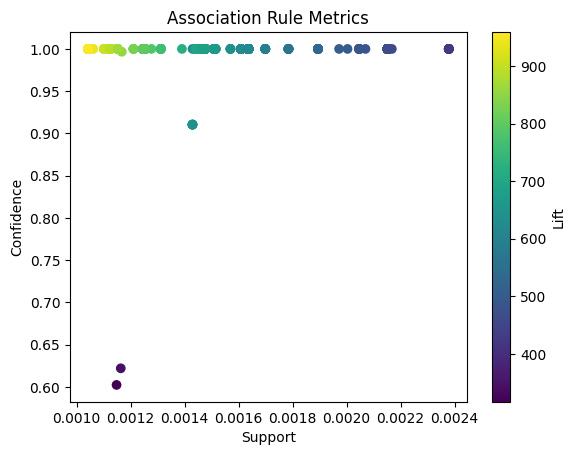

In [24]:
supports = [rule.support for rule in rules]
confidences = [rule.ordered_statistics[0].confidence for rule in rules]
lifts = [rule.ordered_statistics[0].lift for rule in rules]

plt.scatter(supports, confidences, c=lifts, cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rule Metrics')
plt.show()


## Product recommendations


In [25]:
def recommend(item, rules):
    recommendations = []
    for rule in rules:
        if item in rule.items:
            consequent = rule.ordered_statistics[0].items_add
            recommendations.append((consequent, rule.ordered_statistics[0].confidence, rule.ordered_statistics[0].lift))
    # Sort by confidence and lift
    recommendations.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return recommendations[:5]  # Return top 5 recommendations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
item = 'B002QWHJOU'  # Replace with the desired item
recommendations = recommend(item, rules)

print(f"Recommendations for {item}:")
for rec in recommendations:
    recommended_items = ', '.join(rec[0])
    print(f"Items: {recommended_items}, Confidence: {rec[1]:.2f}, Lift: {rec[2]:.2f}")

Recommendations for B002QWHJOU:
Items: B002QWHJOU, Confidence: 1.00, Lift: 420.43
Items: B002QWP89S, Confidence: 1.00, Lift: 420.43
Items: B002QWP8H0, Confidence: 1.00, Lift: 420.43
Items: B002QWHJOU, B002QWP89S, Confidence: 1.00, Lift: 420.43
Items: B002QWHJOU, B002QWP8H0, Confidence: 1.00, Lift: 420.43


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
